Source Code for question 2 and 4 (filtering related questions, sharp and blur)

In [2]:
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
#base => copy results to base
#image => we perform the filtering on that
#mn_filter => the actual filter
#k => qoefficient !
#mode => convolution or corrolation

Making filters equivalant to n times application of 3×3 filter

In [3]:
def filter_maker(rep = 2):
    base_dim = 2 * (rep + 1) - 1
    base = np.zeros((base_dim, base_dim))

    mn_filter = np.array(
        [
            [1, 1, 1],
            [1, 1, 1],
            [1, 1, 1],
        ]
    )

    base_height = base.shape[0] or 3
    base_width = base.shape[1] or 3

    dim = 3
    filter_m = mn_filter.shape[0] or 3
    filter_n = mn_filter.shape[1] or 3

    offset_m = int(math.floor(filter_m / 2.0))
    offset_n = int(math.floor(filter_n / 2.0))
    for i in range(base_dim - dim + 1):
        for j in range(base_dim - dim + 1):
            for m in range(filter_m):
                for n in range(filter_n):
                    if 0 <= i + m < base_dim and 0 <= j + n  < base_dim:
                        base[i + m, j + n] += 1

    return base, (1 / np.concatenate(base).sum())

In [53]:
print(filter_maker(2)[0])
print("**************************")
print(filter_maker(3)[0])

[[1. 2. 3. 2. 1.]
 [2. 4. 6. 4. 2.]
 [3. 6. 9. 6. 3.]
 [2. 4. 6. 4. 2.]
 [1. 2. 3. 2. 1.]]
**************************
[[1. 2. 3. 3. 3. 2. 1.]
 [2. 4. 6. 6. 6. 4. 2.]
 [3. 6. 9. 9. 9. 6. 3.]
 [3. 6. 9. 9. 9. 6. 3.]
 [3. 6. 9. 9. 9. 6. 3.]
 [2. 4. 6. 6. 6. 4. 2.]
 [1. 2. 3. 3. 3. 2. 1.]]


Diffrent filters that we will need for averaging and sharpening and...

In [105]:
_33_filter = np.array(
    [
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
    ]
)

_33_filter_weighted = np.array(
    [
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1],
    ]
)
_55_filter = np.array(
    [
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]
    ]
)

robert_edge_filter_1 = np.array(
    [
        [1,  0],
        [0, -1]
    ]
)

robert_edge_filter_2 = np.array(
    [
        [ 0, 1],
        [-1, 0]
    ]
)

temp = np.array(
    [
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ]
)

__33_filter = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9],
    ]
)

In order to imporve filter application performance I utilized DP, dynamic programming, this helps us because we don't need to calculate some rows and coloumns multiple times.

In [99]:
def filter_image(base : np.ndarray, image : np.ndarray, mn_filter : np.ndarray, k=1, mode="conv", ignore_clipping=False):
    if mode == "conv":
        mn_filter = np.rot90(mn_filter, 2)
    elif mode == "cor":
        pass
    else:
        return
    base_height = base.shape[0] or 3
    base_width = base.shape[1] or 3

    image_height = image.shape[0] or 3
    image_width = image.shape[1] or 3

    filter_m = mn_filter.shape[0] or 3
    filter_n = mn_filter.shape[1] or 3
    base = base.astype(np.float64)
    mn_filter = mn_filter.astype(np.float64)
    mn_filter[:, :] *= k

    offset_m = int(math.floor(filter_m / 2.0))
    offset_n = int(math.floor(filter_n / 2.0))
    for i in range(image_height):
        for j in range(image_width):
            for m in range(filter_m):
                for n in range(filter_n):
                    #calculating stuff multiple times!!
                    if 0 <= i + (m - offset_m) < image_height and 0 <= j + (n - offset_n) < image_width:
                        base[i, j, :3] += image[i + (m - offset_m), j + (n - offset_n), :3] * mn_filter[m, n]
    if not ignore_clipping:
        base = np.clip(base, 0, 255)
    if(image.shape[2] == 4):
        base[:image_height, :image_width, 3] = 255
    return base

In [84]:
def fast_equal_filter_image(base : np.ndarray, image : np.ndarray, mn_filter : np.ndarray, k=1, mode="conv", ignore_clipping=False):
    if mode == "conv":
        mn_filter = np.rot90(mn_filter, 2)
    elif mode == "cor":
        pass
    else:
        return
    base_height = base.shape[0] or 3
    base_width = base.shape[1] or 3

    image_height = image.shape[0] or 3
    image_width = image.shape[1] or 3

    filter_m = mn_filter.shape[0] or 3
    filter_n = mn_filter.shape[1] or 3

    print(filter_m, filter_n)
    offset_m = int(math.floor(filter_m / 2.0))
    offset_n = int(math.floor(filter_n / 2.0))
    base = base.astype(np.float64)
    mn_filter = mn_filter.astype(np.float64)
    mn_filter[:, :] *= k
    sw = 0
    for i in range(image_height):
        sw = 0 if i % 2 == 0 else 1
        if sw == 1:
            j = image_width - 1
            while j >= 0:
                if j == image_width - 1:
                    for n in range(filter_n):
                        if 0 <= i - 1 + (0 - offset_m) < image_height and 0 <= j + (n - offset_n) < image_width:
                            base[i, j, :3] -= image[i - 1 + (0 - offset_m), j + (n - offset_n), :3] * mn_filter[0, n]
                        if 0 <= i + (filter_m - 1 - offset_m) < image_height and 0 <= j + (n - offset_n) < image_width:
                            base[i, j, :3] += image[i + (filter_m - 1 - offset_m), j + (n - offset_n), :3] * mn_filter[filter_m - 1, n]
                    base[i, j, :3] += base[i - 1, j, :3]
                elif j < (image_width - 1):
                    for m in range(filter_m):
                        if 0 <= i + (m - offset_m) < image_height and 0 <= j + (0 - offset_n) < image_width:
                            base[i, j, :3] += image[i + (m - offset_m), j + (0 - offset_n), :3] * mn_filter[m, 0]
                        if 0 <= i + (m - offset_m) < image_height and 0 <= j + 1 + (filter_n - 1 - offset_n) < image_width:
                            base[i, j, :3] -= image[i + (m - offset_m), j + 1 + (filter_n - 1 - offset_n), :3] * mn_filter[m, filter_n - 1]
                    base[i, j, :3] += base[i, j + 1, :3]
                j -= 1
        else:
            j = 0
            while j < image_width:
                if j == 0 and i > 0:
                    for n in range(filter_n):
                        if 0 <= i - 1 + (0 - offset_m) < image_height and 0 <= j + (n - offset_n) < image_width:
                            base[i, j, :3] -= image[i - 1 + (0 - offset_m), j + (n - offset_n), :3] * mn_filter[0, n]
                        if 0 <= i + (filter_m - 1 - offset_m) < image_height and 0 <= j + (n - offset_n) < image_width:
                            base[i, j, :3] += image[i + (filter_m - 1 - offset_m), j + (n - offset_n), :3] * mn_filter[filter_m - 1, n]
                    base[i, j, :3] += base[i - 1, j, :3]
                if j == 0 and i == 0:
                    for m in range(filter_m):
                        for n in range(filter_n):
                            if 0 <= i + (m - offset_m) < image_height and 0 <= j + (n - offset_n) < image_width:
                                base[i, j, :3] += image[i + (m - offset_m), j + (n - offset_n), :3] * mn_filter[m, n]
                elif j > 0:
                    for m in range(filter_m):
                        if 0 <= (i + (m - offset_m)) < image_height and 0 <= ((j - 1) + (0 - offset_n)) < image_width:
                            base[i, j, :3] -= image[i + (m - offset_m), j - 1 + (0 - offset_n), :3] * mn_filter[m, 0]
                        if 0 <= (i + (m - offset_m)) < image_height and 0 <= (j + (filter_n - 1 - offset_n)) < image_width:
                            base[i, j, :3] += image[i + (m - offset_m), j + (filter_n - 1 - offset_n), :3] * mn_filter[m, filter_n - 1]
                    base[i, j, :3] += base[i, j - 1, :3]

                j += 1
    if not ignore_clipping:
        base = np.clip(base, 0, 255)    
    if(image.shape[2] == 4):
        base[:image_height, :image_width, 3] = 255

    return base

3 3
5 5
7 7


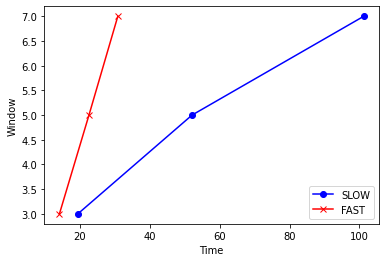

In [85]:
child = Image.open("child.jpg").convert("RGB")
child = np.array(child)
fig, ax = plt.subplots()
ax.set_xlabel("Time")
ax.set_ylabel("Window")
_y = [2 * (i + 2) - 1 for i in range(3)]
slow = []
fast = [] 

import time
for i in range(1, 4):
    start = time.time()
    f, k = filter_maker(i)
    filter_image(np.zeros(child.shape), child, f, k=k)
    end = time.time()
    slow.append(end - start)

for i in range(1, 4):
    start = time.time()
    f, k = filter_maker(i)
    fast_equal_filter_image(np.zeros(child.shape), child, f, k=k)
    end = time.time()
    fast.append(end - start)
    

ax.plot(slow, _y, marker='o', color="blue", label="SLOW")
ax.legend()
ax.plot(fast, _y, marker='x', color="red", label="FAST")
ax.legend()
plt.show()

3 3
3 3
3 3
3 3
3 3


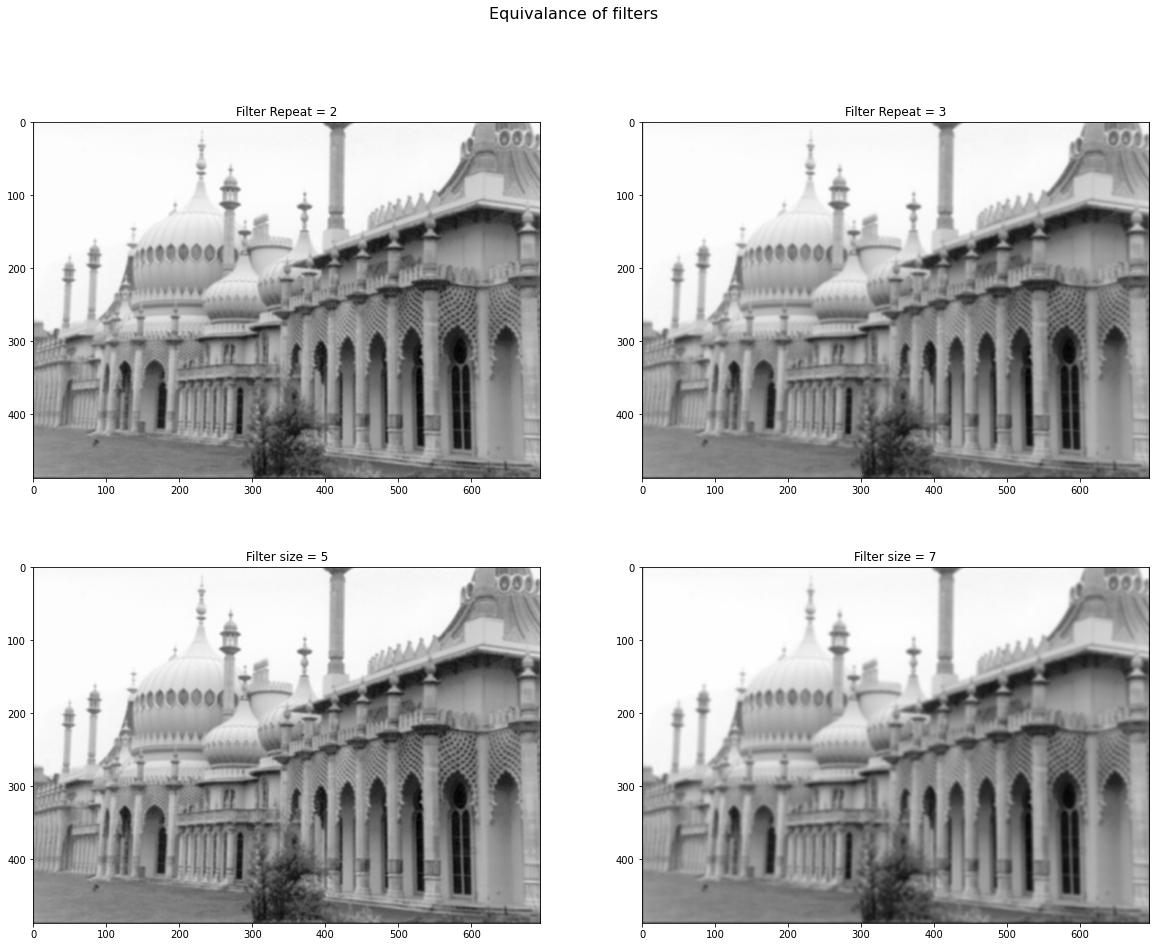

In [86]:
mosque = Image.open("mosque.bmp").convert("RGB")
mosque = np.array(mosque)

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Equivalance of filters', fontsize=16)

for i in range(2, 4):
    f, k = filter_maker(i)
    x = filter_image(np.zeros(mosque.shape), mosque, f, k=k)
    axs[1][i - 2].imshow(x.astype(np.int32))
    axs[1][i - 2].set_title('Filter size = ' + str(2 * (i + 1) - 1))

for j in range(1, 3):
    base = np.zeros(mosque.shape)
    res = fast_filter_image(base, mosque, _33_filter, k=1/9)
    for i in range(j):
        base = np.zeros(mosque.shape)
        res = fast_equal_filter_image(base, res, _33_filter, k=1/9)
    axs[0][j - 1].imshow(res.astype(np.int32))
    axs[0][j - 1].set_title('Filter Repeat = ' + str(j + 1))

plt.show()

In [23]:
def robert_edge(base, x, y):
    x_height = x.shape[0]
    x_width = x.shape[1]
    for i in range(x_height):
        for j in range(x_width):
            for g in range(x.shape[2]):
                base[i, j, g] = int(math.sqrt((x[i, j, g]**2) + (y[i, j, g]**2)))
    base = np.clip(base, 0, 255)
    return base

5 5


[]

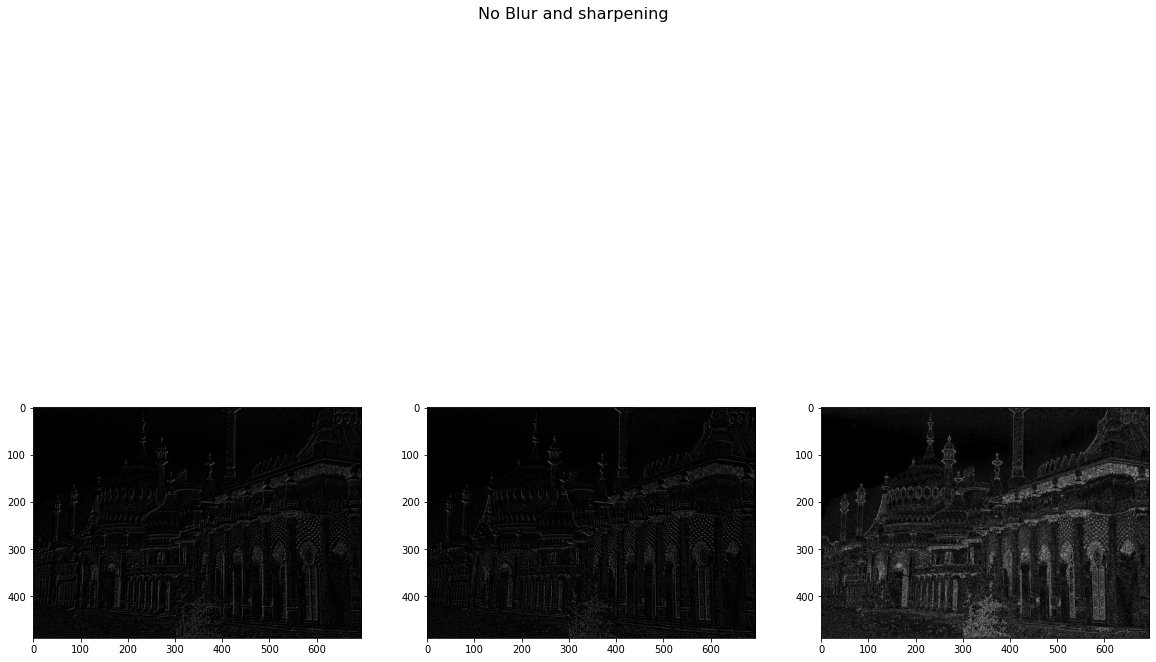

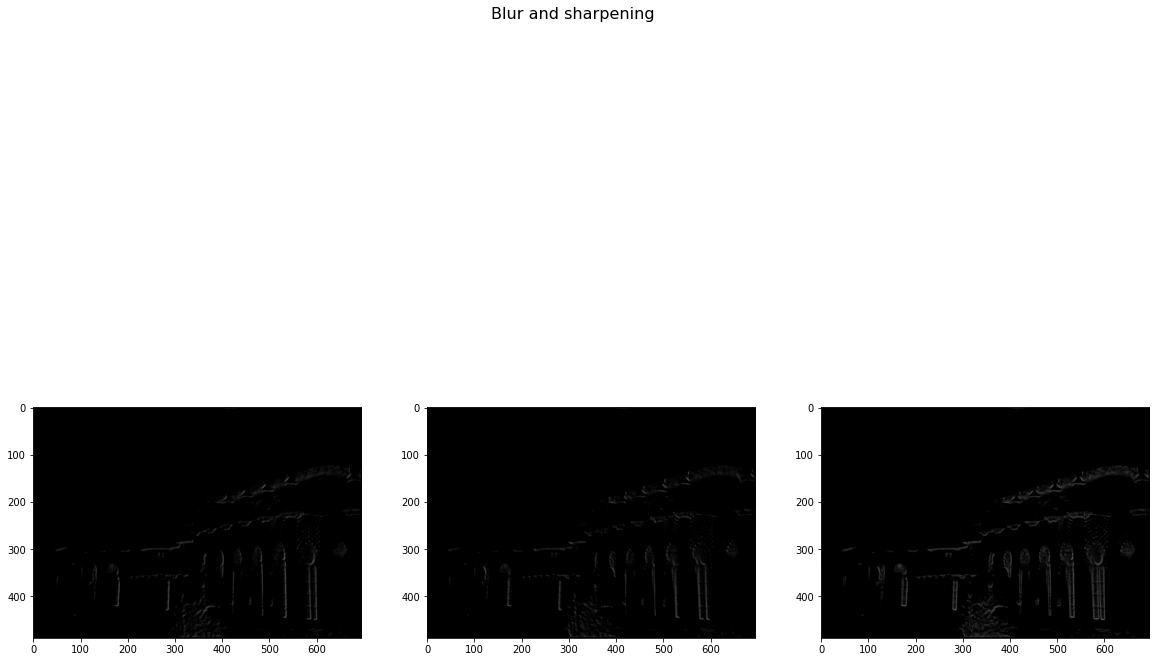

In [104]:
mosque = Image.open("mosque.bmp").convert("RGB")
mosque = np.array(mosque)
fig, axs = plt.subplots(1, 3, figsize=(20, 15))
fig.suptitle('No Blur and sharpening', fontsize=16)
x = filter_image(np.zeros(mosque.shape), mosque, robert_edge_filter_1, k=1, ignore_clipping=True)
axs[0].imshow(np.clip(x, 0, 255).astype(np.int32))

y = filter_image(np.zeros(mosque.shape), mosque, robert_edge_filter_2, k=1, ignore_clipping=True)
axs[1].imshow(np.clip(y, 0, 255).astype(np.int32))

res = robert_edge(np.zeros(mosque.shape), x, y)
def extract_image(image, name="res"):
    pil_img=Image.fromarray((image).astype(np.uint8))
    pil_img.save("./" + str(name) +  ".png")
    return pil_img
extract_image(res, "no_blur_robert")
axs[2].imshow(res.astype(np.int32))
plt.plot()

fig, axs = plt.subplots(1, 3, figsize=(20, 15))
fig.suptitle('Blur and sharpening', fontsize=16)

mosque = fast_equal_filter_image(np.zeros(mosque.shape), mosque, _55_filter, k=1/9)

x = filter_image(np.zeros(mosque.shape), mosque, robert_edge_filter_1, k=1)
axs[0].imshow(x.astype(np.int32))

y = filter_image(np.zeros(mosque.shape), mosque, robert_edge_filter_2, k=1)
axs[1].imshow(y.astype(np.int32))

res = robert_edge(np.zeros(mosque.shape), x, y)
extract_image(res, "blur_robert")
axs[2].imshow(res.astype(np.int32))
plt.plot()

In [102]:
def unsharp_mask_pipeline(base, image, _filter, k, weight=0.5):
    """
    1. blur
    2. subtract blured
    3. add mask to original
    """
    blur = np.zeros(image.shape)
    blur = filter_image(blur, image, _filter, k=k)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            base[i, j, :] = (image[i, j, :]) + np.round((image[i, j, :] - blur[i, j, :]) * (weight))
    base = np.clip(base, 0, 255)
    return base

In [89]:
def unsharp_mask_median_pipeline(base, image, filter_m, filter_n, weight=0.5):
    """
    1. blur
    2. subtract blured
    3. add mask to original
    """

    base_height = base.shape[0] or 3
    base_width = base.shape[1] or 3

    image_height = image.shape[0] or 3
    image_width = image.shape[1] or 3
    window = np.zeros(filter_m * filter_n)
    offset_m = int(math.floor(filter_m / 2.0))
    offset_n = int(math.floor(filter_n / 2.0))
    blur = np.zeros(image.shape)

    for i in range(image_height):
        for j in range(image_width):
            k = 0
            for m in range(filter_m):
                for n in range(filter_n):
                    if 0 <= i + (m - offset_m) < image_height and 0 <= j + (n - offset_n) < image_width:
                        window[k] = image[i + (m - offset_m), j + (n - offset_n), 0]
                        k += 1
            window.sort()
            blur[i, j, :] = window[(filter_m * filter_n) // 2]
    blur = np.clip(blur, 0, 255)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            base[i, j, :] = (image[i, j, :]) + np.round((image[i, j, :] - blur[i, j, :]) * (weight))
    base = np.clip(base, 0, 255)
    return base, blur

In [97]:
def adaptive_laplacian_pipeline(base1, base2, image, _filter, adaptives, k, threshhold, weight=1):
    base1 = filter_image(base1, image, _filter, k=k)

    for i in range(8):
        temp = filter_image(np.zeros(image.shape), image, adaptives[i], k)
        for ii in range(image.shape[0]):
            for jj in range(image.shape[1]):
                for rgb in range(base2[8].shape[2]):
                    if temp[ii, jj, rgb] >= threshhold:
                        base2[8][ii, jj, rgb] += temp[ii, jj, rgb]
    base2[8] = np.clip(base2[8], 0, 255)

    laplac = np.zeros(image.shape)
    adaptive_lap = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            laplac[i, j, :] = (image[i, j, :]) + np.round(base1[i, j, :] * (weight))
            adaptive_lap[i, j, :] = (image[i, j, :]) + np.round(base1[i, j, :] * (weight))
    adaptive_lap = np.clip(adaptive_lap, 0, 255)
    laplac = np.clip(laplac, 0, 255)
    return base1, base2[8], laplac, adaptive_lap

In [91]:
def generate_adaptive_sharpening_filter(_filter):
    filters = []
    for i in range(3):
        for j in range(3):
            if i == j and i == 1:
                continue
            temp = np.zeros(_filter.shape)
            if (i == 0 and j == 1) or (j == 0 and i == 1) or (i == 2 and j == 1) or (i == 1 and j == 2):
                temp[1, 1] = 2
            else:
                temp[1, 1] = 1
            temp[i, j] = _filter[i, j]
            filters.append(temp)
    filtera = np.array(filters)
    return filters

In [92]:
_33_filter_laplacian = np.array(
    [
        [-1, -2, -1],
        [-2, 12, -2],
        [-1, -2, -1],
    ]
)

adaptive_lap = generate_adaptive_sharpening_filter(_33_filter_laplacian)

Text(0.5, 1.0, 'Original image')

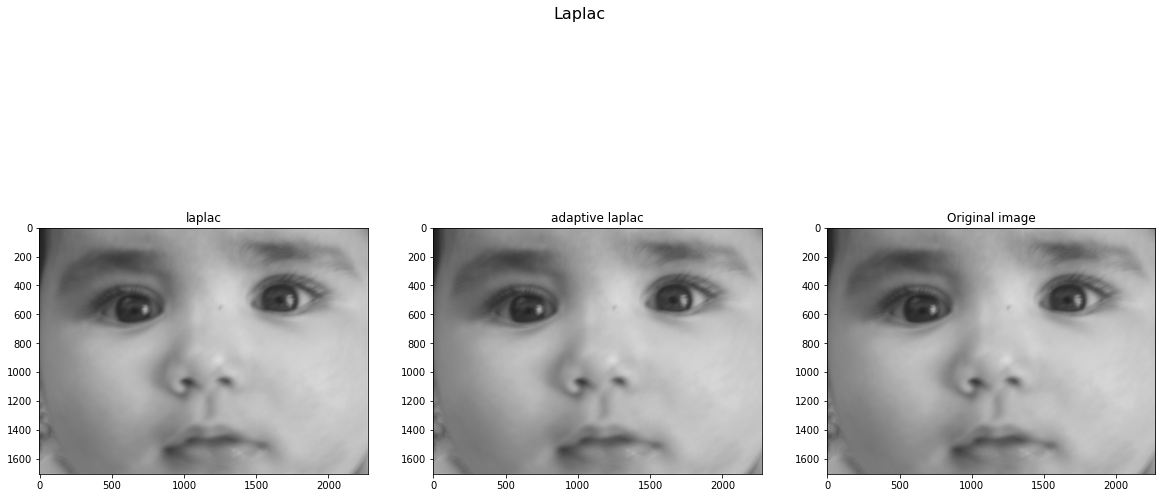

In [100]:
face1 = Image.open("face1.jpg").convert("RGB")
face1 = np.array(face1)
x , y, xx, yy= adaptive_laplacian_pipeline(np.zeros(face1.shape), np.array([np.zeros(face1.shape) for _ in range(9)]), face1, _33_filter_laplacian, adaptive_lap, 1/16, 100)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Laplac', fontsize=16)
axs[0].imshow(xx.astype(np.int32))
axs[0].set_title('laplac')
axs[1].imshow(yy.astype(np.int32))
axs[1].set_title('adaptive laplac')
axs[2].imshow(face1.astype(np.int32))
axs[2].set_title('Original image')

Text(0.5, 1.0, 'Original image')

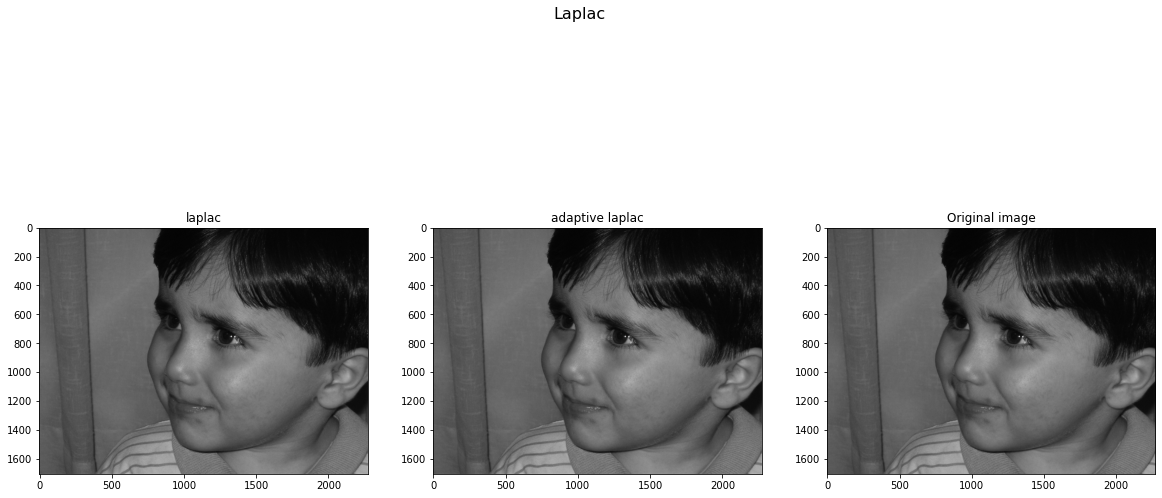

In [101]:
face2 = Image.open("face2.jpg").convert("RGB")
face2 = np.array(face2)
x , y, xx, yy= adaptive_laplacian_pipeline(np.zeros(face2.shape), np.array([np.zeros(face2.shape) for _ in range(9)]), face2, _33_filter_laplacian, adaptive_lap, 1/16, 100)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Laplac', fontsize=16)
axs[0].imshow(xx.astype(np.int32))
axs[0].set_title('laplac')
axs[1].imshow(yy.astype(np.int32))
axs[1].set_title('adaptive laplac')
axs[2].imshow(face2.astype(np.int32))
axs[2].set_title('Original image')

Text(0.5, 1.0, 'Original image')

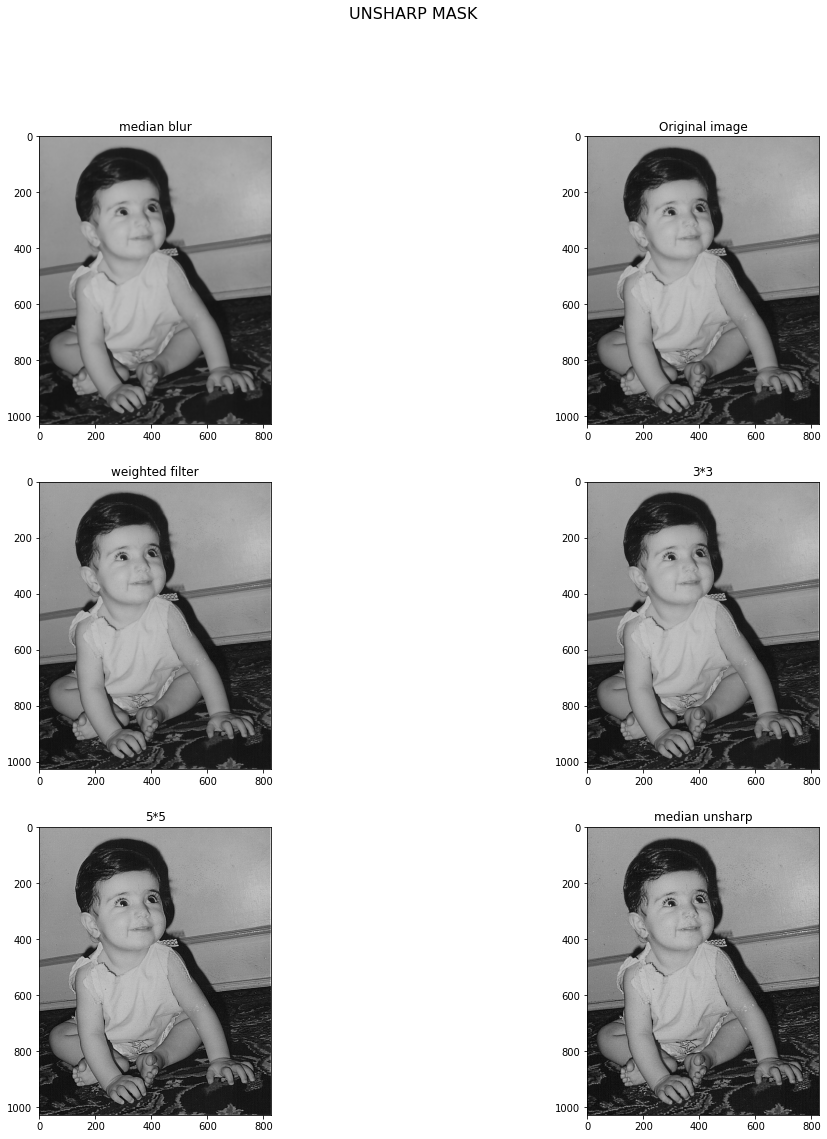

In [107]:
child = Image.open("child.jpg").convert("RGB")
child = np.array(child)
weighted_filter = unsharp_mask_pipeline(np.zeros(child.shape), child, _33_filter_weighted, 1/16, 2)

normal_33_filter = unsharp_mask_pipeline(np.zeros(child.shape), child, _33_filter, 1/9, 2)

normal_55_filter = unsharp_mask_pipeline(np.zeros(child.shape), child, _55_filter, 1/25, 2)

y, median_blur = unsharp_mask_median_pipeline(np.zeros(child.shape), child, 7, 7, 2)

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle('UNSHARP MASK', fontsize=16)
axs[1][0].imshow(weighted_filter.astype(np.int32))
axs[1][0].set_title('weighted filter')
axs[1][1].imshow(normal_33_filter.astype(np.int32))
axs[1][1].set_title('3*3')
axs[2][0].imshow(normal_55_filter.astype(np.int32))
axs[2][0].set_title('5*5')
axs[2][1].imshow(y.astype(np.int32))
axs[2][1].set_title('median unsharp')
axs[0][0].imshow(median_blur.astype(np.int32))
axs[0][0].set_title('median blur')
axs[0][1].imshow(child.astype(np.int32))
axs[0][1].set_title('Original image')